##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

### Import Required Libraries 

In [566]:
#pip install xgboost
#pip install emoji

#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [567]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import re
import emoji
from string import digits

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectKBest

### Import and Preprocess Data

In [568]:
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

A function to preprocess our texts:

In [569]:
def preprocess_text(x):
    
    # Replace username, URL
    x = re.sub('http[s]?://\S+', 'URL', x)
    x = re.sub("@[A-Za-z0-9_]+",'USERNAME', x)

    # Translate emojis
    x = emoji.demojize(x, delimiters=("", ""))
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    x = " ".join(lemmatizer.lemmatize(word) for word in x.split())

    # Remove digits
    transl = str.maketrans('', '', digits)
    x = x.translate(transl)

    return x

In [570]:
# Inspect class distribution
print("Netural classes: ", np.mean(train_data[['sentiment']].values =='neutral'))
print("Positive classes: ", np.mean(train_data[['sentiment']].values =='positive'))
print("Negative classes: ", np.mean(train_data[['sentiment']].values =='negative'))

Netural classes:  0.5806348041464086
Positive classes:  0.24896798458856986
Negative classes:  0.17039721126502155


Then we separate the tweet text and the label (sentiment). 

In [571]:
#separating instance and label for Train
X_train_raw = [preprocess_text(x[0]) for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

#separating instance and label for Test
X_test_raw = [preprocess_text(x[0]) for x in test_data[['text']].values]

tfidf_vectorizer = TfidfVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_raw)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf = tfidf_vectorizer.transform(X_test_raw)

print("Train feature space size (using TFIDF):",X_train_tfidf.shape)
print("Test feature space size (using TFIDF):",X_test_tfidf.shape)


Train feature space size (using TFIDF): (21802, 25755)
Test feature space size (using TFIDF): (6099, 25755)


For unpreprocessed data

In [572]:
#separating instance and label for Train
X_train_raw_no_prep = [x[0] for x in train_data[['text']].values]
Y_train_no_prep = [x[0] for x in train_data[['sentiment']].values]

#separating instance and label for Test
X_test_raw_no_prep = [x[0] for x in test_data[['text']].values]

tfidf_vectorizer_no_prep = TfidfVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using TFIDF
X_train_tfidf_no_prep = tfidf_vectorizer_no_prep.fit_transform(X_train_raw_no_prep)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_tfidf_no_prep = tfidf_vectorizer_no_prep.transform(X_test_raw_no_prep)

print("Train feature space size (without preprocessing, using TFIDF):",X_train_tfidf_no_prep.shape)
print("Test feature space size (without preprocessing, using TFIDF):",X_test_tfidf_no_prep.shape)

Train feature space size (without preprocessing, using TFIDF): (21802, 44045)
Test feature space size (without preprocessing, using TFIDF): (6099, 44045)


### Feature Selection

In [573]:
chi2_selector = SelectKBest(chi2, k=2800)
X_train = chi2_selector.fit_transform(X_train_tfidf, Y_train)
X_test = chi2_selector.transform(X_test_tfidf)

In [574]:
# Inspect some raw features
print(tfidf_vectorizer_no_prep.get_feature_names_out()[70:90])

['0dgxlejij2' '0dv9dd8ss1' '0dydug2b3x' '0dyljrpsmx' '0dyssvzwq4'
 '0e6je9xxyb' '0eak3qeago' '0ergvxs61w' '0esdqggbwm' '0fdiieydqm'
 '0ffsxzymap' '0ftdlggkt7' '0fxt61o8p2' '0gfzy1ev94' '0hdszn5chx'
 '0hecetzwg9' '0hkajxuuiu' '0hr5zp6ryu' '0hsi2cflkl' '0hu5p2eiul']


In [575]:
# Inspect some chosen features
for feat_num in chi2_selector.get_support(indices=True)[2785:2790]:
    print(tfidf_vectorizer.get_feature_names_out()[feat_num])

# Inspect some other chosen features
for feat_num in chi2_selector.get_support(indices=True)[:5]:
    print(tfidf_vectorizer.get_feature_names_out()[feat_num])

üíú
üò
üòä
üòå
üòç
abaddonnewwarlorddomination
abbott
abbreviated
abc
abdicate


In [576]:
# An evaluation function to streamline the fitting and evaluation process
def eval(clf, X_train, Y_train, verbose=False, cv=False):
    X_train_eval, X_val, y_train_eval, y_val = train_test_split(X_train, Y_train, 
                                                                train_size=0.8, 
                                                                random_state=0)

    y_val_pred = clf.fit(X_train_eval, y_train_eval).predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    if verbose:
        print("Accuracy: ", accuracy)
        print(classification_report(y_val, y_val_pred, target_names=set(Y_train), zero_division=0))
        cm = confusion_matrix(y_val, y_val_pred, labels=clf.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                        display_labels=clf.classes_)
        disp.plot(cmap='magma')
        plt.show()
    
    if cv:
        print("Cross Validation Accuracy: (5-fold)", np.mean(cross_val_score(clf, X_train, Y_train, cv=5)))
    
    return accuracy

### Baseline Model: 0-R

Baseline Model: 0-R, Without Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.5732630130703967
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       740
     neutral       0.57      1.00      0.73      2500
    negative       0.00      0.00      0.00      1121

    accuracy                           0.57      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.57      0.42      4361



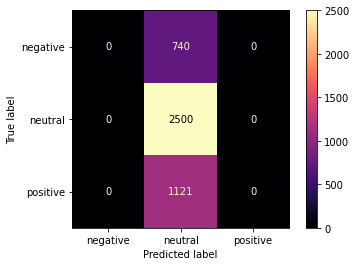

0.5732630130703967

In [577]:
# Without Preprocessing, Feature Selection, Hyperparameter Tuning
print("Baseline Model: 0-R, Without Preprocessing, Feature Selection, Hyperparameter Tuning")
zero_r = DummyClassifier(strategy="most_frequent")
eval(zero_r, X_train_tfidf_no_prep, Y_train_no_prep, verbose=True)

Baseline Model: 0-R, With Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.5732630130703967
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00       740
     neutral       0.57      1.00      0.73      2500
    negative       0.00      0.00      0.00      1121

    accuracy                           0.57      4361
   macro avg       0.19      0.33      0.24      4361
weighted avg       0.33      0.57      0.42      4361



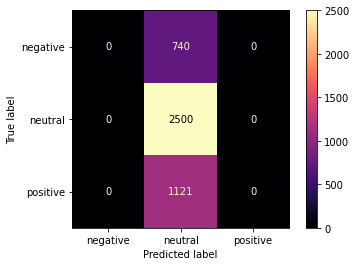

0.5732630130703967

In [578]:
# With Preprocessing, Feature Selection, Hyperparameter Tuning
print("Baseline Model: 0-R, With Preprocessing, Feature Selection, Hyperparameter Tuning")
zero_r = DummyClassifier(strategy="most_frequent")
eval(zero_r, X_train, Y_train, verbose=True)

### Model 1: Linear SVM (One vs All)

Model: Linear SVM (One vs All), Without Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.6606282962623251
              precision    recall  f1-score   support

    positive       0.56      0.37      0.44       740
     neutral       0.68      0.82      0.74      2500
    negative       0.65      0.50      0.56      1121

    accuracy                           0.66      4361
   macro avg       0.63      0.56      0.58      4361
weighted avg       0.65      0.66      0.65      4361



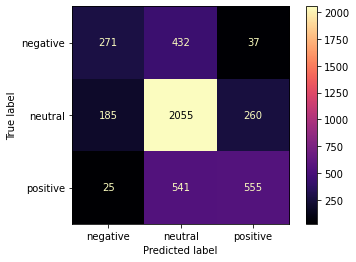

0.6606282962623251

In [579]:
# Without Preprocessing, Feature Selection, Hyperparameter Tuning
print("Model: Linear SVM (One vs All), Without Preprocessing, Feature Selection, Hyperparameter Tuning")
lsvc = svm.LinearSVC()
eval(lsvc, X_train_tfidf_no_prep, Y_train_no_prep, verbose=True)

Model: Linear SVM (One vs All), With Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.6938775510204082
              precision    recall  f1-score   support

    positive       0.56      0.53      0.54       740
     neutral       0.74      0.78      0.76      2500
    negative       0.68      0.62      0.65      1121

    accuracy                           0.69      4361
   macro avg       0.66      0.64      0.65      4361
weighted avg       0.69      0.69      0.69      4361



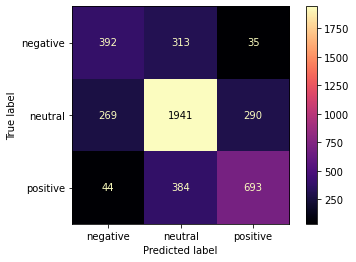

0.6938775510204082

In [580]:
# With Preprocessing, Feature Selection, Hyperparameter Tuning
print("Model: Linear SVM (One vs All), With Preprocessing, Feature Selection, Hyperparameter Tuning")
lsvc = svm.LinearSVC(C=1, class_weight='balanced')
eval(lsvc, X_train, Y_train, verbose=True)

### Model 2: Logistic Regression

Model: Logistic Regression, Without Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.6640678743407475
              precision    recall  f1-score   support

    positive       0.64      0.24      0.35       740
     neutral       0.65      0.90      0.76      2500
    negative       0.72      0.41      0.53      1121

    accuracy                           0.66      4361
   macro avg       0.67      0.52      0.54      4361
weighted avg       0.67      0.66      0.63      4361



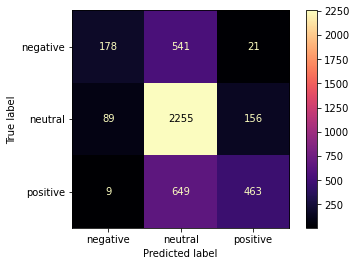

0.6640678743407475

In [581]:
# Without Preprocessing, Feature Selection, Hyperparameter Tuning
print("Model: Logistic Regression, Without Preprocessing, Feature Selection, Hyperparameter Tuning")
logistic = LogisticRegression(max_iter=300000)
eval(logistic, X_train_tfidf_no_prep, Y_train_no_prep, verbose=True)

Model: Logistic Regression, With Preprocessing, Feature Selection, Hyperparameter Tuning
Accuracy:  0.6629213483146067
              precision    recall  f1-score   support

    positive       0.48      0.69      0.56       740
     neutral       0.78      0.63      0.70      2500
    negative       0.63      0.73      0.67      1121

    accuracy                           0.66      4361
   macro avg       0.63      0.68      0.64      4361
weighted avg       0.69      0.66      0.67      4361



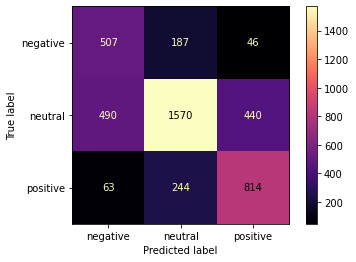

0.6629213483146067

In [582]:
# With Preprocessing, Feature Selection, Hyperparameter Tuning
print("Model: Logistic Regression, With Preprocessing, Feature Selection, Hyperparameter Tuning")
logistic = LogisticRegression(solver='sag', C=2, class_weight='balanced')
eval(logistic, X_train, Y_train, verbose=True)

### Inspect Our Predictions and Actual Values

In [583]:
y_lr_full = logistic.predict(X_train)
y_svm_full = lsvc.predict(X_train)
idx = range(152,153)

print(pd.DataFrame({'tweet': train_data.iloc[idx].text, 
            "true ": train_data.iloc[idx].sentiment, 
            "predicted (svm) ": y_svm_full[idx],
            "predicted (lr) ": y_lr_full[idx]
}))

                                                 tweet     true   \
152   @heatherfard yo! hot #uber driver last night ...  positive   

    predicted (svm)  predicted (lr)   
152          neutral        positive  


### Tune the hyperparameter For Logistic Regression

[12] [46] [7] [17] [22]
[14] [111] [8] [20] [23]
[15] [131] [9] [22] [24]
[18] [216] [10] [26] [26]
[17] [228] [10] [27] [31]
[18] [295] [11] [31] [36]


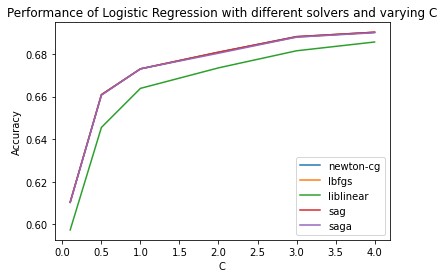

In [584]:
accuracies_newton =[]
accuracies_lbfgs =[]
accuracies_liblinear =[]
accuracies_sag =[]
accuracies_saga =[]

C = [0.1, 0.5, 1, 2, 3, 4]
for c in C:
    logistic_newton = LogisticRegression(solver='newton-cg', C=c)
    accuracies_newton.append(eval(logistic_newton, X_train, Y_train))
    logistic_lbfgs = LogisticRegression(solver='lbfgs', C=c, max_iter=500)
    accuracies_lbfgs.append(eval(logistic_lbfgs, X_train, Y_train))
    logistic_liblinear = LogisticRegression(solver='liblinear', C=c)
    accuracies_liblinear.append(eval(logistic_liblinear, X_train, Y_train))
    logistic_sag = LogisticRegression(solver='sag', C=c)
    accuracies_sag.append(eval(logistic_sag, X_train, Y_train))
    logistic_saga = LogisticRegression(solver='saga', C=c)
    accuracies_saga.append(eval(logistic_saga, X_train, Y_train))
    # print(
    # logistic_newton.n_iter_, 
    # logistic_lbfgs.n_iter_,
    # logistic_liblinear.n_iter_,
    # logistic_sag.n_iter_,
    # logistic_saga.n_iter_
    # )

plt.plot(C,  accuracies_newton, label='newton-cg')
plt.plot(C,  accuracies_lbfgs, label='lbfgs')
plt.plot(C,  accuracies_liblinear, label='liblinear')
plt.plot(C,  accuracies_sag, label='sag')
plt.plot(C,  accuracies_saga, label='saga')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Performance of Logistic Regression with different solvers and varying C")
plt.legend()
plt.show()

### Tune the hyperparameter For SVM

In [ ]:
from sklearn.svm import SVC
accuracies_lsvc =[]
accuracies_linear =[]
accuracies_poly =[]
accuracies_rbf =[]
accuracies_sigmoid =[]


C = [0.1, 0.5, 1, 2, 3, 4]
for c in C:
    lsvc = svm.LinearSVC(C=c)
    accuracies_lsvc.append(eval(lsvc, X_train, Y_train))
    linear = SVC(C=c, kernel='linear')
    accuracies_linear.append(eval(linear, X_train, Y_train))
    poly = SVC(C=c, kernel='poly')
    accuracies_poly.append(eval(poly, X_train, Y_train))
    rbf = SVC(C=c, kernel='rbf')
    accuracies_rbf.append(eval(rbf, X_train, Y_train))
    sigmoid = SVC(C=c, kernel='sigmoid')
    accuracies_sigmoid.append(eval(sigmoid, X_train, Y_train))

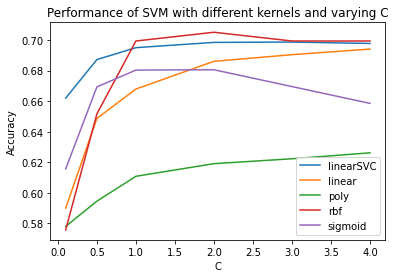

In [614]:
plt.plot(C,  accuracies_lsvc, label='linearSVC')
plt.plot(C,  accuracies_linear, label='linear')
plt.plot(C,  accuracies_poly, label='poly')
plt.plot(C,  accuracies_rbf, label='rbf')
plt.plot(C,  accuracies_sigmoid, label='sigmoid')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Performance of SVM with different kernels and varying C")
plt.legend()
plt.show()

### Runtimes for different SVM

In [611]:
import time

start_rbf = time.time()
svc_rbf = SVC(C=1, kernel='rbf')
svc_rbf.fit(X_train, Y_train)
end_rbf = time.time()
print("Runtime for SVC-rbf:", end_rbf - start_rbf)  

Runtime for SVC-rbf: 150.33643126487732


In [609]:
import time

start_lsvc = time.time()
svc_lsvc = svm.LinearSVC(C=1)
svc_lsvc.fit(X_train, Y_train)
end_lsvc = time.time()
print("Runtime for LSVC:", end_lsvc - start_lsvc)  

Runtime for LSVC: 1.8627839088439941


### Tuning Chi-Sq Selector

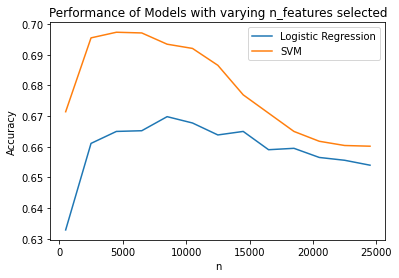

In [602]:
accuracies_svm = []
accuracies_lr = []
K = list(range(500, X_train_tfidf.shape[1], 2000))
for k in K:
    chi2_selector = SelectKBest(chi2, k=k)
    X_train_csq = chi2_selector.fit_transform(X_train_tfidf, Y_train)
    lsvc = svm.LinearSVC(C=1, class_weight='balanced')
    logistic = LogisticRegression(solver='sag', C=2, class_weight='balanced')
    accuracies_svm.append(eval(lsvc, X_train_csq, Y_train))
    accuracies_lr.append(eval(logistic, X_train_csq, Y_train))
plt.plot(K,  accuracies_lr, label='Logistic Regression')
plt.plot(K,  accuracies_svm, label='SVM')
plt.xlabel("n")
plt.ylabel("Accuracy")
plt.title("Performance of Models with varying n_features selected")
plt.legend()
plt.show()

### Build our Final Model and Generate Predictions for Test Data (Using Logistic Regression)

In [588]:
final_clf = LogisticRegression(solver='sag', C=2, class_weight='balanced')
y_pred = final_clf.fit(X_train, Y_train).predict(X_test)
output = pd.DataFrame(data={'id': test_data['id'], 'sentiment': y_pred})

In [589]:
output.to_csv("pred.csv",index=False)